# **Get data**

In [1]:
import pandas as pd

data = pd.read_csv("../input/newsgroup20bbcnews/bbc-text.csv")

# **Exploring data**

In [2]:
data.shape

(2225, 2)

In [3]:
data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
data.columns

Index(['category', 'text'], dtype='object')

In [5]:
data['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

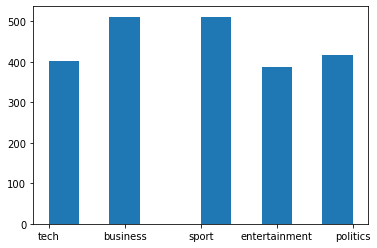

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.hist(data['category'])
plt.show()

# **Data cleansing and transforming**

In [7]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

signs = str.maketrans('','',string.punctuation)
stop_words = set(stopwords.words('english'))

def clean_text(row):
    words = [w.lower() for w in row.split()]
    words = [w.translate(signs) for w in words]
    words = [w for w in words if w.isalpha()]
    words = [w for w in words if not w in stop_words]
    new_row = (' ').join(words)
    return new_row

data['text_cls'] = data['text'].apply(clean_text)

In [8]:
lens = [len(i.split()) for i in data['text_cls']]

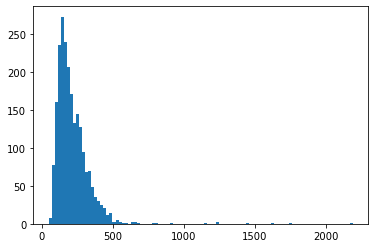

In [9]:
plt.hist(lens, bins=100)
plt.show()

# **Data preparing**

In [10]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

MAX_NB_WORDS = 5000
oov_tok = '<OOV>'

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token=oov_tok)
tokenizer.fit_on_texts(data['text_cls'].values)
word_index = tokenizer.word_index

In [11]:
len(word_index)

30088

In [12]:
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 64
trunc_type = 'post'
padding_type = 'post'

X = tokenizer.texts_to_sequences(data['text_cls'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding=padding_type, truncating=trunc_type)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (2225, 500)


In [13]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

le = LabelEncoder()
le.fit(data['category'].unique())
Y = le.transform(data['category'])

Y_cat = to_categorical(Y,data['category'].nunique())

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 21)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size = 0.2, random_state = 21)
print("train:",X_train.shape,Y_train.shape)
print("valid:",X_val.shape,Y_val.shape)
print("test:",X_test.shape,Y_test.shape)



train: (1601, 500) (1601,)
valid: (401, 500) (401,)
test: (223, 500) (223,)


# **Model**

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(EMBEDDING_DIM)))
model.add(Dense(5, activation='softmax'))

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)
print(model.summary())



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 386,693
Trainable params: 386,693
Non-trainable params: 0
_________________________________________________________________
None


# **Model Training**

In [15]:
epochs = 10
history = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val), verbose=2)

Epoch 1/10
51/51 - 17s - loss: 1.5628 - accuracy: 0.3317 - val_loss: 1.4502 - val_accuracy: 0.4514
Epoch 2/10
51/51 - 15s - loss: 1.0903 - accuracy: 0.5522 - val_loss: 0.9731 - val_accuracy: 0.6334
Epoch 3/10
51/51 - 15s - loss: 0.5848 - accuracy: 0.8538 - val_loss: 0.3015 - val_accuracy: 0.9227
Epoch 4/10
51/51 - 15s - loss: 0.3820 - accuracy: 0.9026 - val_loss: 0.6436 - val_accuracy: 0.8579
Epoch 5/10
51/51 - 15s - loss: 0.2159 - accuracy: 0.9669 - val_loss: 0.2327 - val_accuracy: 0.9501
Epoch 6/10
51/51 - 15s - loss: 0.1596 - accuracy: 0.9644 - val_loss: 0.4326 - val_accuracy: 0.8554
Epoch 7/10
51/51 - 15s - loss: 0.0771 - accuracy: 0.9881 - val_loss: 0.2151 - val_accuracy: 0.9426
Epoch 8/10
51/51 - 15s - loss: 0.0937 - accuracy: 0.9800 - val_loss: 0.1890 - val_accuracy: 0.9377
Epoch 9/10
51/51 - 15s - loss: 0.0221 - accuracy: 0.9988 - val_loss: 0.1358 - val_accuracy: 0.9651
Epoch 10/10
51/51 - 15s - loss: 0.0180 - accuracy: 0.9969 - val_loss: 0.1559 - val_accuracy: 0.9651


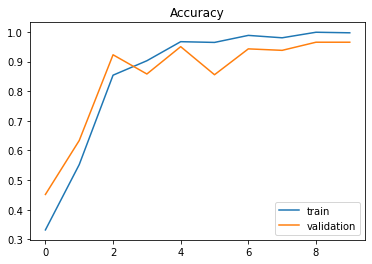

In [16]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

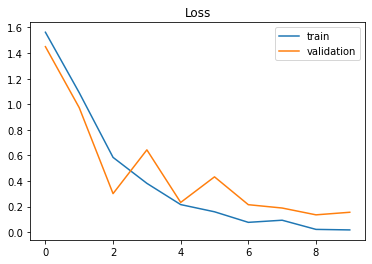

In [17]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# **Model Evaluating**

In [18]:
score, acc = model.evaluate(X_test, Y_test)

print('Test score:', score)
print('Test accuracy:', acc)

7/7 [==============================] - 0s 54ms/step - loss: 0.1758 - accuracy: 0.9417
Test score: 0.17582355439662933
Test accuracy: 0.9417040348052979


In [19]:
text_labels = le.classes_ 
Y_pred = model.predict(X_test)

In [20]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          normalize=False):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.0%'
    else:
        fmt = '.0f'
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

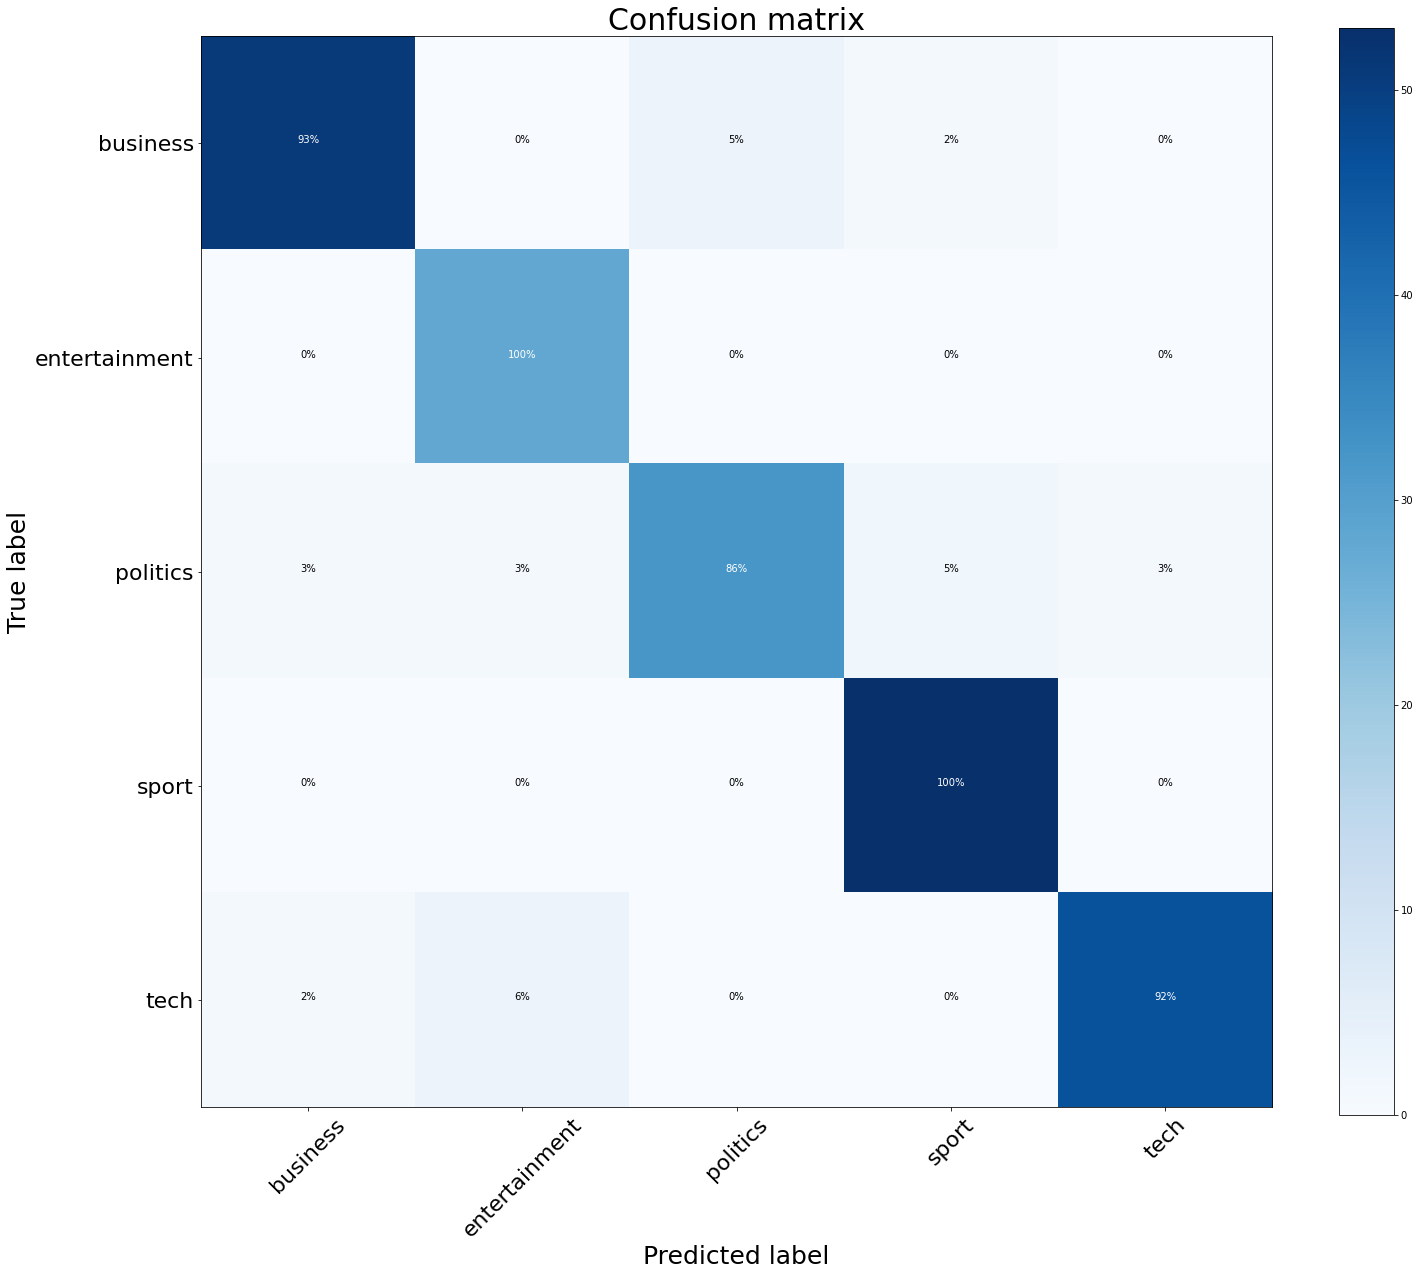

In [21]:
from sklearn.metrics import confusion_matrix
import itertools

cnf_matrix = confusion_matrix(Y_test, Y_pred.argmax(axis=1))
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix", normalize=True)
plt.show()

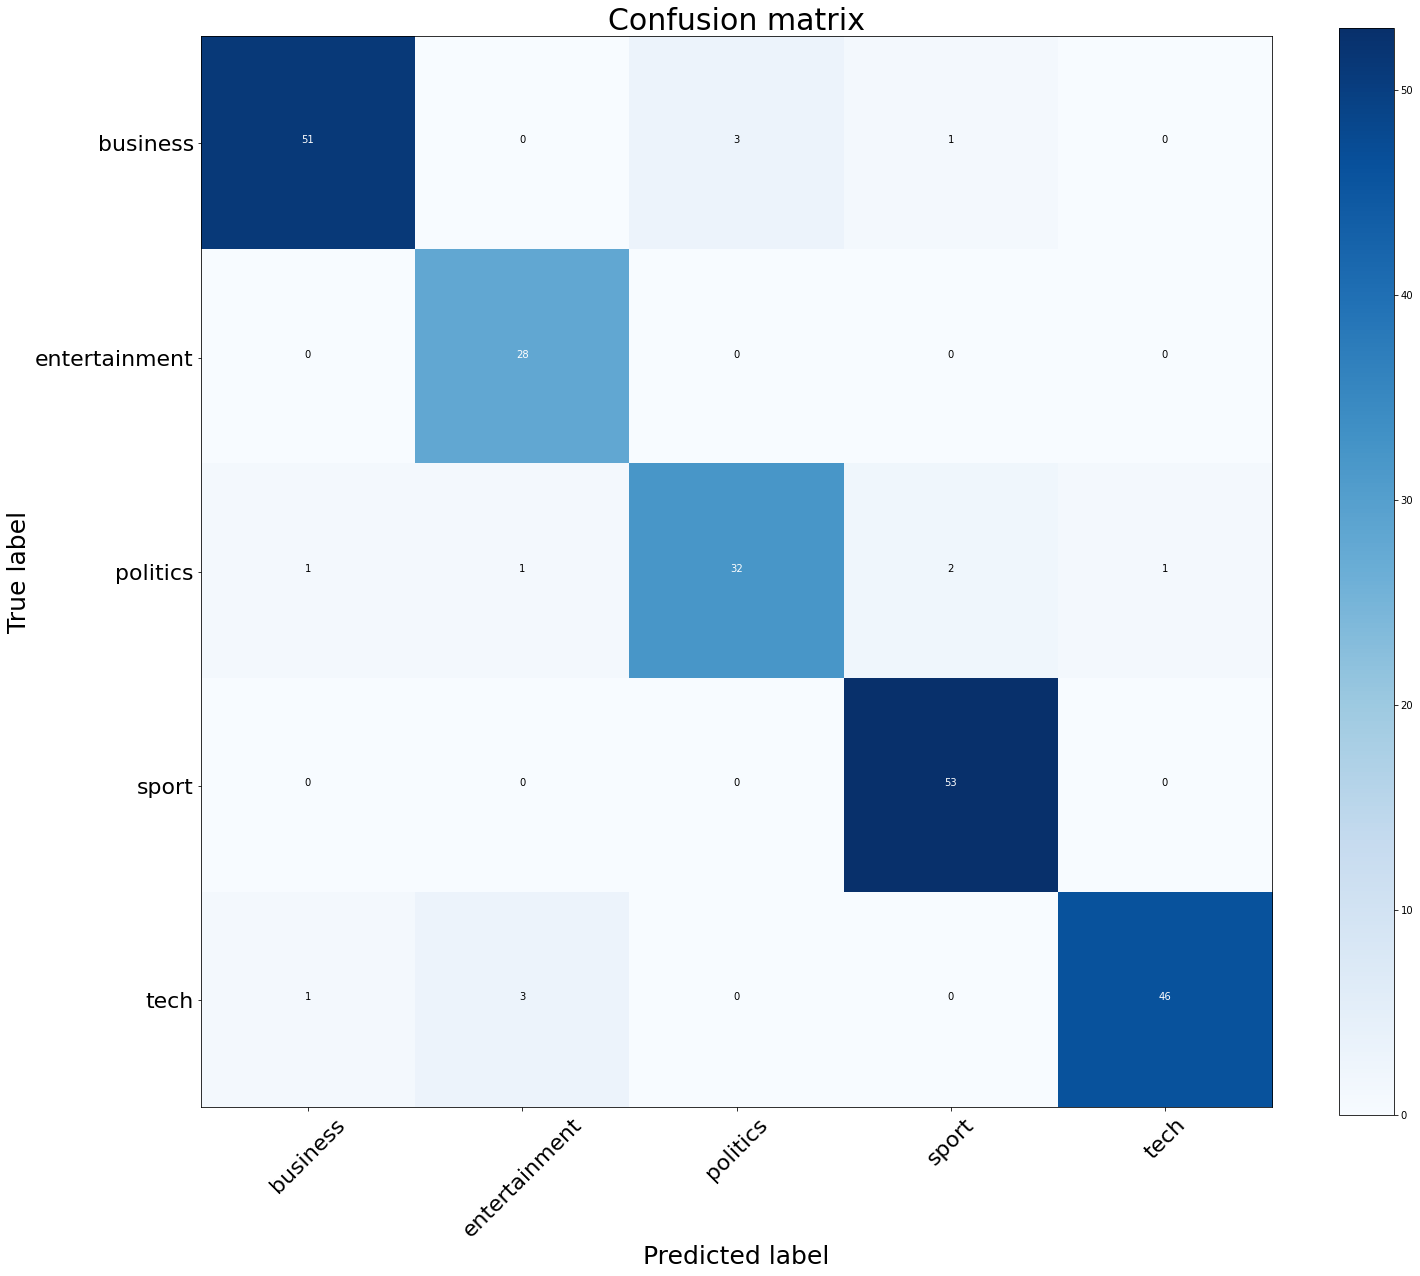

In [22]:
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix", normalize=False)
plt.show()